<a href="https://colab.research.google.com/github/rafaels100/TP_Clustering_LaboDatosUBA/blob/main/TP3_KMeans_Clustering_Pokemon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TP 3: Modelo K-Means clustering para clasificar Pókemons
Dado un dataset de imágenes de Pókemons de 1ra generación en escala de grises, entrenamos un modelo para clasificarlos según las similitudes que presentan los diferentes "clusters" o grupos de Pókemons. El algoritmo K-Means de clusterización encuentra estos clusters y separa los Pókemon según las caracteristicas que encuentre estos comparten (los que son más pequeños, más grandes, más grises, etc).

---



In [ ]:
from google.colab import drive
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#clase para realizar PCA (Componentes principales)
from sklearn.decomposition import PCA
#importamos algoritmos de clusterizacion
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
#silhouette score
from sklearn.metrics import silhouette_score

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


En el siguiente archivo tenemos imagenes de pokemons de 56 pixeles de largo por 68 de alto.

In [ ]:
px = 56
py = 68
filename = '/content/drive/My Drive/TerceraEjercitacion/pokemon_imagenes.p'
file = open(filename, "rb")
data = pickle.load(file)
file.close()

nombres = np.array(data["nombres"])
imagenes = np.array(data["imagenes"])

por otro lado, la informacion sobre los atributos de cada pokemon (funcion) esta en el siguiente dataframe

In [ ]:
filename = "/content/drive/My Drive/TerceraEjercitacion/pokemon_dataframe.csv"
df = pd.read_csv(filename)

Para poder trabajar con algoritmos de reduccion de la dimension y clustering, primero tenemos que representar los datos de sprites como una matriz.
Para eso debemos "desenrollar" a la matriz de pixeles, y ponerla como un vector.

Creo una matriz donde cada fila contendra a un pokemon, y tendra 56*68 columnas, en donde estara la informacion de cada pixel "en una tira".

In [ ]:
data = np.zeros((len(nombres), px * py))
#lleno la matriz con los pixeles de cada pokemon
for n, img in enumerate(imagenes):
    img.resize(px * py)
    data[n, :] = img

1- Usar el criterio de la silueta para verificar que hay un maximo local cerca de k = 8 clusters. Aplicar el algoritmo k-means con k = 8 clusters sobre los datos de sprites (matriz data)

Hago PCA para reducir las dimensiones a sus componentes principales, digamos, a 50 componentes

In [ ]:
n_comp = 100
pca = PCA(n_components=n_comp)
#ajuste y transformacion de los datos
pca.fit(data)
X_pca = pca.transform(data)

Usamos el criterio de la silhueta para encontrar la mejor cantidad k de clusters que agrupan nuestra data. Creamos una lista para guardar los scores de silhouette para cada k

In [ ]:
silhouette_scores = []

Se necesitan al menos dos clusters y a lo sumo N-1 muestras (con N num de muestras) para poder calcular el score de silhouette. Esto es asi porque necesitamos al menos un cluster vecino, y que dichos clusters tengan elementos.
Digamos que quiero mirar los score de silueta desde k = 2 hasta k = 10

Iteramos por cada cluster calculando el score de silhouette

In [ ]:
k = 10
for i in range(2, k):
    #creamos el modelo para la cantidad de clusters i
    kkkmeans = KMeans(n_clusters=i)
    kkkmeans.fit(data)
    #calculamos el score de la silueta
    score = silhouette_score(data, kkkmeans.labels_)
    #lo guardamos en la lista de scores
    silhouette_scores.append(score)

Grafiquemos los score de silhouette para los diferentes k

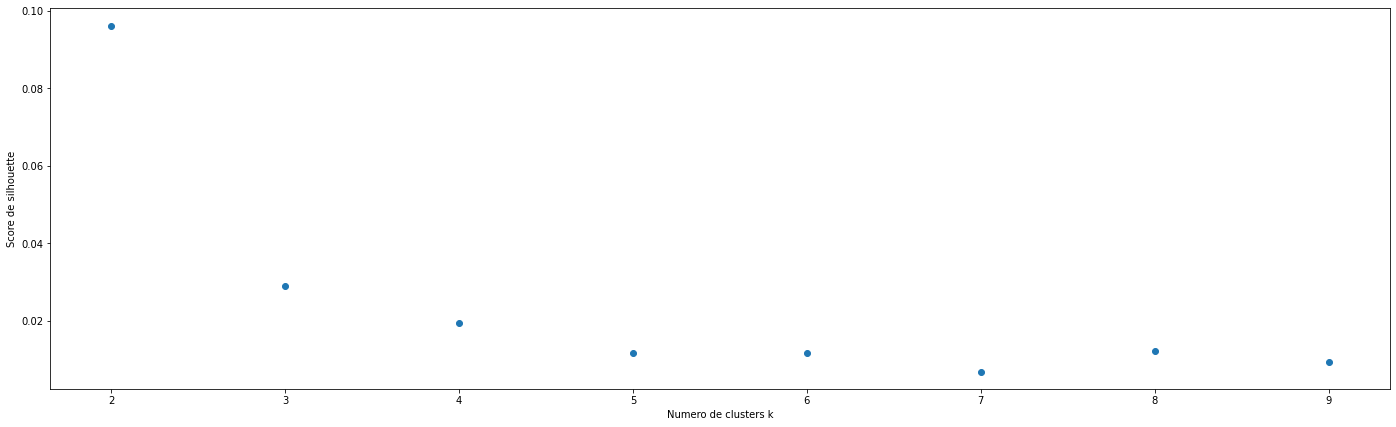

In [ ]:
fig, ax = plt.subplots(figsize=(24,7))
ax.scatter(range(2,k), silhouette_scores)
ax.set_xticks(range(2, k))
ax.set_xlabel("Numero de clusters k")
ax.set_ylabel("Score de silhouette")
plt.show()

Vemos que hay un maximo local en k = 8, por lo que parece un buen numero de clusters para agrupar a los pokemos. Lo utilizo entonces para el estudio siguiente.

2- Aplicamos el algoritmo kmeans con k = 8 y visualizamos los datos en las primeras dos componentes principales, viendo como el algoritmo agrupo a los datos en clusters, utilizando distintos colores para cada uno podemos plotear el dataset en el espacio de las dos primeras componentes principales para darnos una idea de como esta distribuida la data

creacion del modelo kmeans para k = 8

In [ ]:
k = 8
kmeans = KMeans(n_clusters=k)
#ajuste del modelo a los datos reducidos en componentes principales
kmeans.fit(X_pca)

KMeans()

Guardo a los pokemons etiquetados en la siguiente variable

In [ ]:
pokemons_etiquetados = kmeans.labels_
print(pokemons_etiquetados)

[5 3 2 5 4 7 6 2 6 1 2 5 3 3 3 1 0 5 4 1 7 4 6 6 2 1 5 2 6 1 2 1 3 4 5 1 6
 3 0 6 2 0 2 2 4 6 5 1 6 5 6 2 3 0 6 6 6 2 7 3 6 1 2 2 2 6 7 2 1 1 1 1 2 1
 5 2 2 1 7 2 1 5 6 4 1 6 3 3 7 7 3 3 3 1 0 1 7 4 2 2 1 4 3 7 0 5 4 5 6 2 4
 7 2 5 6 2 4 6 7 4 7 6 3 7 6 7 6 3 1 2 0 1 7 6 2 2 6 3 6 1 2 5 7 3 5 2 5 3
 5 7 0 6 1 4 0 6 0 1 1 6 7 4 4 2 4 7 1 7 2 2 4 1 1 4 1 6 3 1 7 3 4 0 2 4 4
 4 5 1 3 5 1 6 7 4 2 7 7 5 2 6 7 3 1 1 6 2 4 6 1 6 3 4 5 3 2 4 4 1 1 6 4 1
 6 4 6 2 3 6 1 1 6 3 3 7 4 6 5 4 7 6 5 7 1 4 4 4 2 5 6 1 7 3 1 7 3 1 6 5 6
 0 1 3 2 2 3 2 6 4 5 1 2 2 1 2 3 6 1 3 7 1 6 6 6 5 6 5 7 7 7 4 6 4 6 6 2 3
 5 7 5 4 2 0 3 0 7 3 7 1 6 1 4 2 1 4 0 0 4 3 1 6 2 3 6 3 6 1 1 4 4 5 1 5 2
 2 6 4 2 7 3 2 6 5 5 1 6 3 7 2 1 6 6 2 6 3 5 0 6 3 3 6 7 3 6 7 6 2 2 3 2 6
 6 0 3 1 2 3 4 7 2 7 1 5 7 5 7 2 2 3 6 6 5 2 2 3 6 3 7 7 4 1 6 4 5 7 5 2 3
 3 7 1 0 1 1 6 3 2 6 2 0 6 0 7 4 6 3 2 2 7 6 6 2 7 2 1 3 5 2 1 3 1 3 4 3 5
 2 5 3 0 7 6 7 6 5 2 6 1 3 7 6 4 0 5 7 6 0 1 5 7 4 2 6 2 6 6 6 6 2 5 1 3 5
 6 6 2 0 3 3 1 3 5 3 7 0 

Obtengo las posiciones de los centroides para plotearlas luego

In [ ]:
centroides = kmeans.cluster_centers_

Hacemos un scatter plot de cada uno de los datos en la primera y segunda componente de las componentes principales, con los colores de sus etiquetas

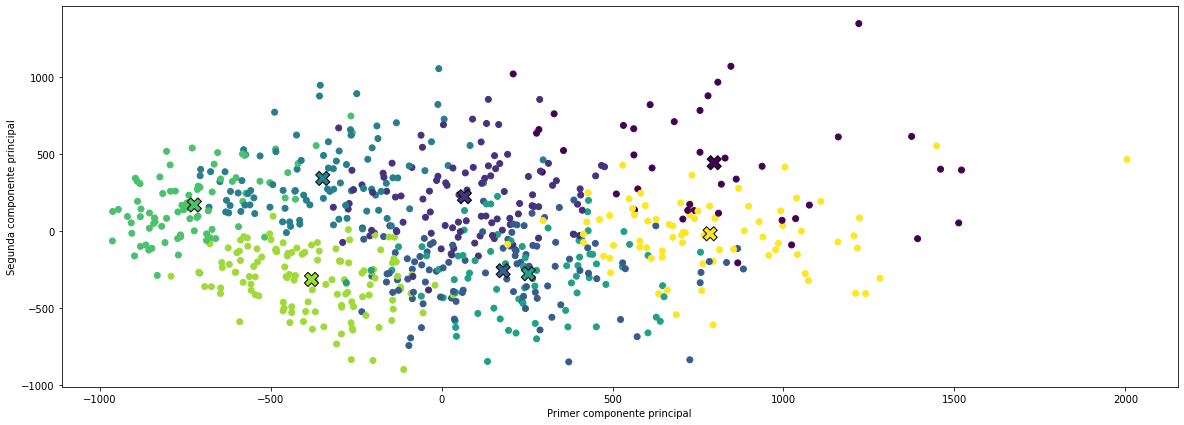

In [ ]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=pokemons_etiquetados)
#ploteo los centroides, tambien en funcion de la etiqueta que capturan
ax.scatter(centroides[:, 0], centroides[:, 1], marker="X", s=200, linewidths=1,
           c=np.unique(pokemons_etiquetados), edgecolors="black")

ax.set_xlabel("Primer componente principal")
ax.set_ylabel("Segunda componente principal")
plt.show()

3 - Para cada uno de los k=8 clusters, visualizamos los 10 primeros pokemons de cada cluster

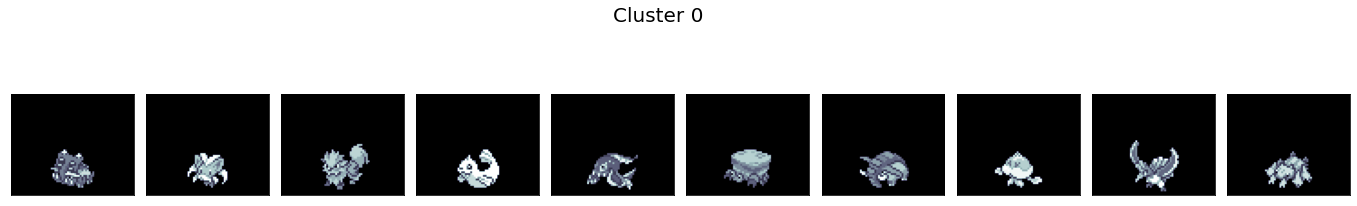

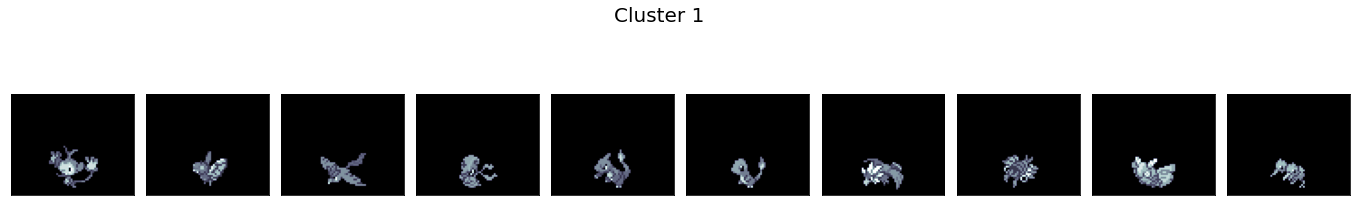

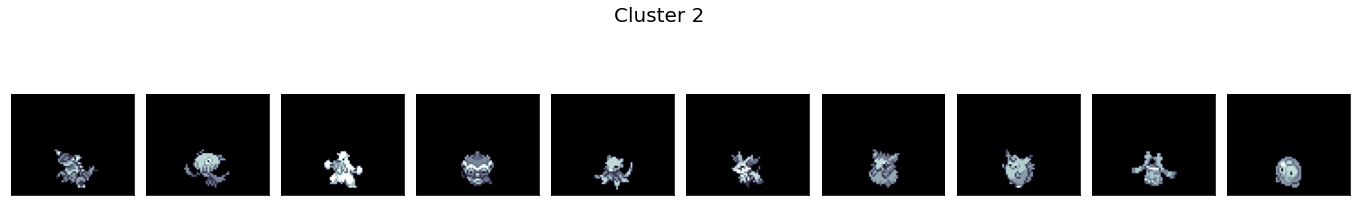

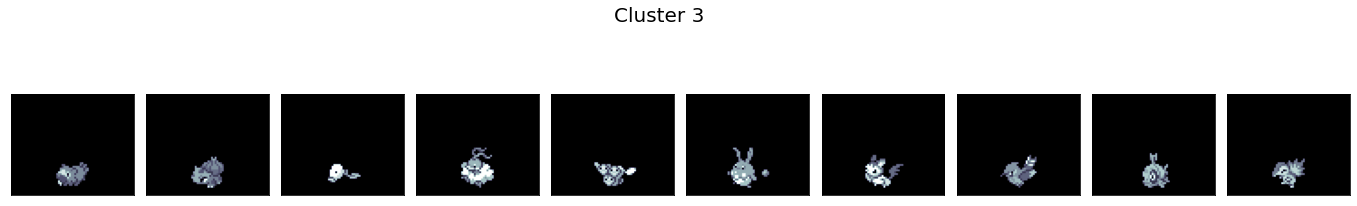

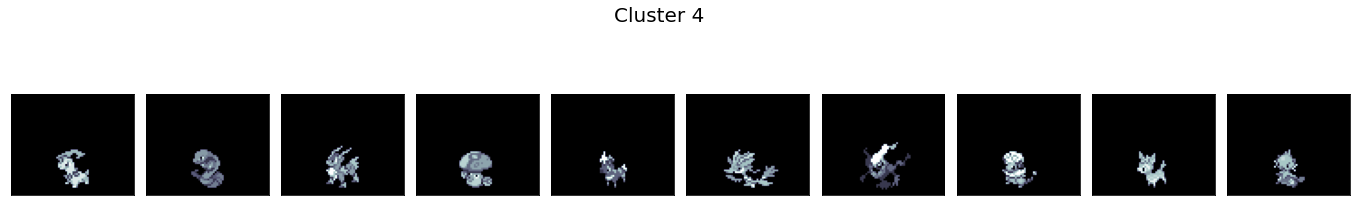

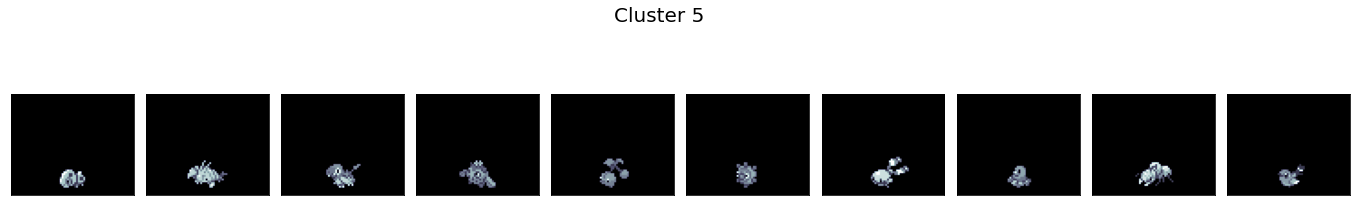

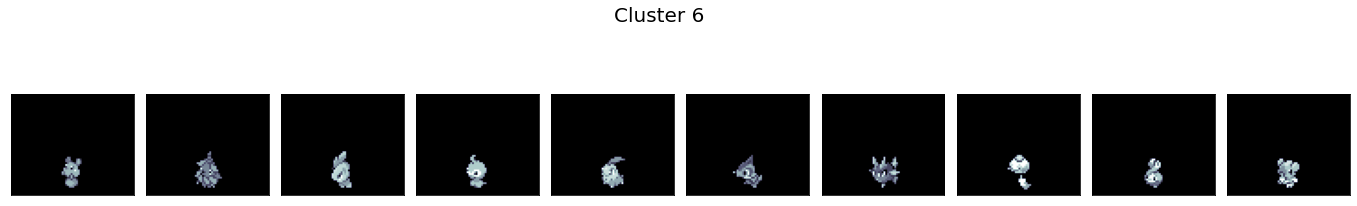

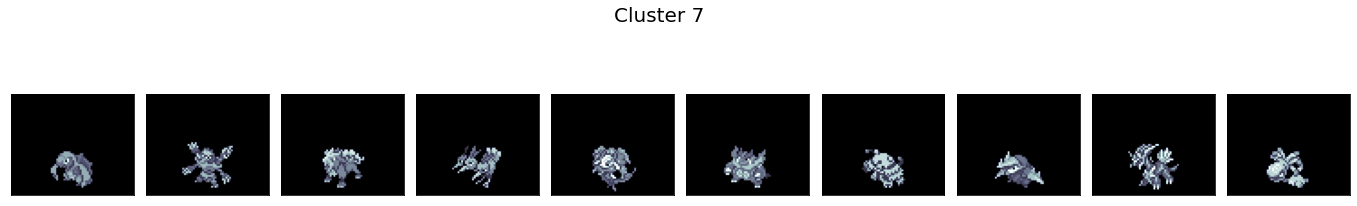

In [ ]:
for i in range(0, k):
    #guardamos los indices donde aparecen fotos de este cluster
    index = np.nonzero(pokemons_etiquetados==i)[0]
    #me quedo con los 10 primeros pokemons del cluster
    cant_fotos = 10
    index = index[:cant_fotos]
    #para todas las fotos encontradas, las rescato de la base de datos
    #original y les doy un formato px*py (56x68 en este caso) para poder
    #plotearlas. Es decir, las convierto de vector de 3808 filas a matriz de
    #56 filas x 68 columnas:
    estos_pokemons = data[index].reshape(cant_fotos, px, py)
    #ploteo los pokemons de este cluster
    #primero creo la grilla donde ploteare las imagenes
    fig, axes = plt.subplots(1, cant_fotos, figsize=(24 ,4),
                             subplot_kw={"xticks":[], "yticks":[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    fig.suptitle(f"Cluster {i}", fontsize=20)
    #ploteo las imagenes en la grilla
    for i, ax in enumerate(axes.flat):
        ax.imshow(estos_pokemons[i], cmap="bone")

plt.show()

4- En un mismo grafico de barras, mostrar el valor promedio de los atributos SP, Attack, Defense y Speed de cada cluster. Cual es el cluster de pokemons mas fuertes ?

Debo usar los indices para crear dataframes de cada cluster, y luego, mediante el nombre, relacionarlo con el dataframe de pokemons

In [ ]:
#los stats que me interesan son
stats = ["HP", "Attack", "Defense", "Speed"]
#creo una lista donde almacenar los promedios de los stats de cada cluster
promedios_k = []
#itero por todos los clusters para calcular el promedio de los stats
for i in range(0, k):
    #obtengo los indices de los pokemons en este cluster
    index_ki = np.nonzero(pokemons_etiquetados==i)[0]
    #obtengo los nombres de dichos pokemons
    nom_poks_ki = nombres[index_ki]
    #del dataframe de pokemons, extraigo la informacion de los pokemons
    #de este cluster
    df_ki = df[df.Name.isin(nom_poks_ki)]
    #obtengo las columnas HP, Attack, Defese y Speed de los pokemons de
    #este cluster
    df_ki_stats = df_ki.loc[:, stats]
    #calculo el promedio de cada una de ellas
    prom_stats_ki = df_ki_stats.mean(axis=0)
    #guardo el promedio de los stats de este cluster en la lista de promedios
    promedios_k.append(prom_stats_ki)


ploteo en un grafico de barras los stats para cada cluster

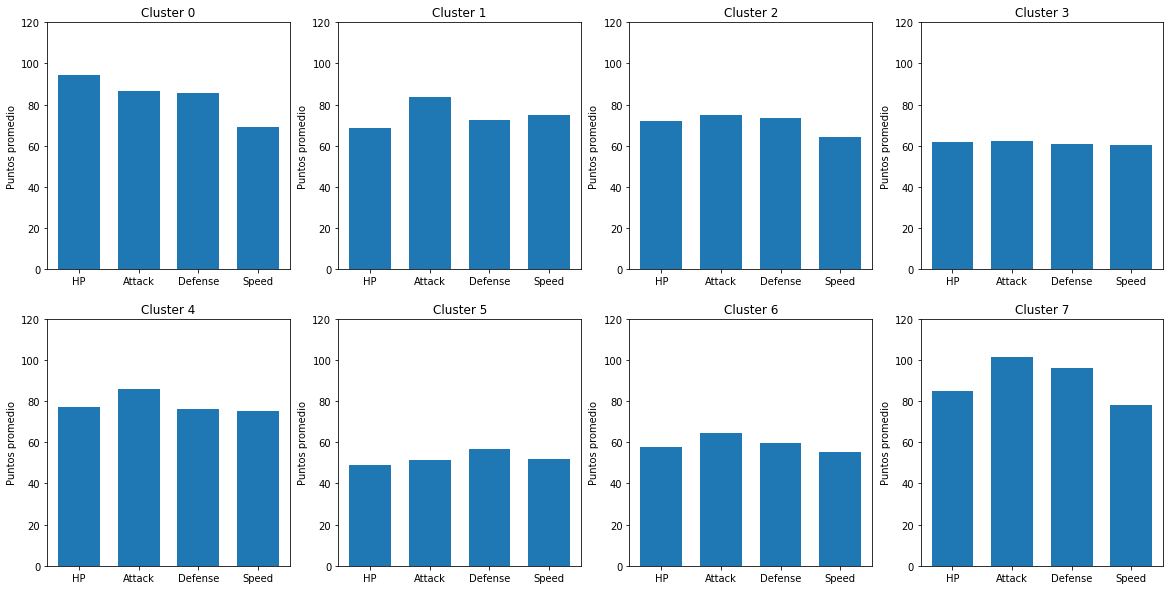

In [ ]:
fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(figsize=(20,10), nrows=2, ncols=4)
ax1.bar(stats, promedios_k[0], width=0.7)
ax1.set_ylim(top=120)
ax1.set_title("Cluster 0")
ax1.set_ylabel("Puntos promedio")
ax2.bar(stats, promedios_k[1], width=0.7)
ax2.set_ylim(top=120)
ax2.set_title("Cluster 1")
ax2.set_ylabel("Puntos promedio")
ax3.bar(stats, promedios_k[2], width=0.7)
ax3.set_ylim(top=120)
ax3.set_title("Cluster 2")
ax3.set_ylabel("Puntos promedio")
ax4.bar(stats, promedios_k[3], width=0.7)
ax4.set_ylim(top=120)
ax4.set_title("Cluster 3")
ax4.set_ylabel("Puntos promedio")
ax5.bar(stats, promedios_k[4], width=0.7)
ax5.set_ylim(top=120)
ax5.set_title("Cluster 4")
ax5.set_ylabel("Puntos promedio")
ax6.bar(stats, promedios_k[5], width=0.7)
ax6.set_ylim(top=120)
ax6.set_title("Cluster 5")
ax6.set_ylabel("Puntos promedio")
ax7.bar(stats, promedios_k[6], width=0.7)
ax7.set_ylim(top=120)
ax7.set_title("Cluster 6")
ax7.set_ylabel("Puntos promedio")
ax8.bar(stats, promedios_k[7], width=0.7)
ax8.set_ylim(top=120)
ax8.set_title("Cluster 7")
ax8.set_ylabel("Puntos promedio")
plt.show()

Vemos que el cluster de pokemons mas fuertes es el 7

5 - Para cada pokemon del cluster, dado su indice, evaluo en la matriz de data original cuantos elementos no vacios tiene la fila correspondiente a cada pokemon (previo a pasar por PCA). Eso indica cuantos pixeles tiene encendidos en su foto original.

In [ ]:
#creo una lista para almacenar los tamaños de los pokemons
tamaños_k = []
#itero por todos los clusters calculando el tamaño de los pokemons
for i in range(0, k):
    #obtengo los indices de los pokemons en este cluster
    index_ki = np.nonzero(pokemons_etiquetados==i)[0]
    #obtengo, de la matriz de data original pre PCA, la info de los
    #pixeles de cada uno de estos pokemons
    pixeles_pok_ki = data[index_ki]
    #cuento la cantidad de pixeles no vacios para todos estos pokemons
    pix_no_vacios = np.count_nonzero(pixeles_pok_ki)
    #guardo la cantidad de pixeles no vacios en la lista de tamaños
    tamaños_k.append(pix_no_vacios)

print(tamaños_k)

[12414, 21210, 20881, 16328, 16625, 9701, 17897, 23639]


Ploteo en grafico de barras el tamaño para cada cluster, y lo comparo con el poder del cluster

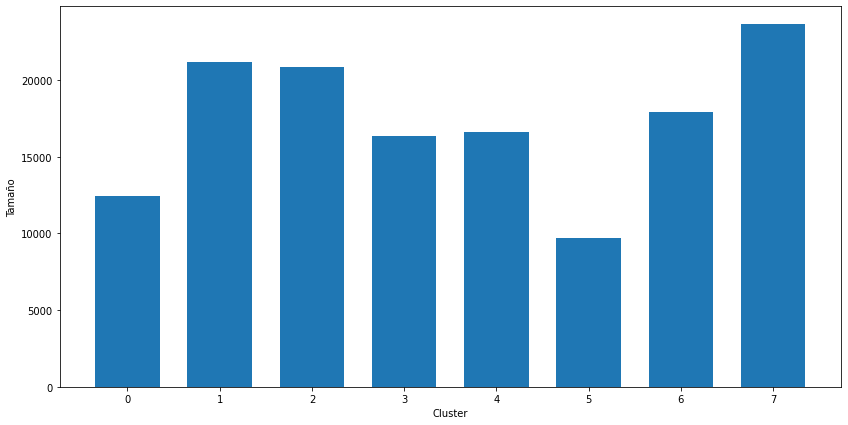

In [ ]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(range(0, k), tamaños_k, width=0.7)
ax.set_xlabel("Cluster")
ax.set_ylabel("Tamaño")
plt.show()

Vemos que si hay una relacion entre el tamaño de los pokemons en los clusters y su poder, pues el cluster 7 tiene el mejor promedio de estadisticas y tambien es el cluster con los pokemons de mayor tamaño, mientras que el cluster 5 tiene promedio de estadisticas bajo y tiene a los pokemons mas pequeños.

6 - Obtengo los nombres de los pokemons y el correspondiente dataframe del cluster. Luego, me quedo con un subset del dataframe, aquellas filas en cuya columna de Legendary aparezca un si. Luego cuento la cantidad de filas de ese dataframe. Esa es la cantidad de pokemons legendarios en el cluster.
Luego, hago un grafico de torta que muestre la proporcion de legendarios y no legendarios sobre el total en el cluster.


In [ ]:
#creo una lista para almacenar la proporcion de pokemons no legendarios
#y legendarios de cada cluster
prop_noLegs_legs_k = []
#itero por cada cluster calculando dichas proporciones
for i in range(0, k):
    index_ki = np.nonzero(pokemons_etiquetados==i)[0]
    #la cantidad de pokemons en el cluster es de
    cant_poks_ki = len(index_ki)
    #obtengo los nombres de dichos pokemons
    nom_poks_ki = nombres[index_ki]
    #del dataframe de pokemons, extraigo la informacion de los pokemons
    #de este cluster
    df_ki = df[df.Name.isin(nom_poks_ki)]
    #obtengo los pokemons legendarios de este cluster
    df_ki_legs = df_ki[df_ki["Legendary"]==True].loc[:, ["#", "Name", "Legendary"]]
    cant_poks_legs_ki = len(df_ki_legs)
    #la cantidad de no legendarios sera la cantidad total menos la de legendarios
    cant_poks_noLegs_ki = cant_poks_ki - cant_poks_legs_ki
    #calculo la proporcion de no legendarios sobre el total vs
    #la proporcion de legendarios sobre el total.
    #La proporcion de pokemons no legendarios del cluster es de:
    prop_poks_noLegs_ki = cant_poks_noLegs_ki/cant_poks_ki
    #la proporcion de pokemons legendarios del cluster es
    prop_poks_legs_ki = cant_poks_legs_ki/cant_poks_ki
    #junto en una lista y añado a la lista de proporciones de los clusters
    props_ki = [prop_poks_noLegs_ki, prop_poks_legs_ki]
    prop_noLegs_legs_k.append(props_ki)

print(prop_noLegs_legs_k)

[[0.9512195121951219, 0.04878048780487805], [0.9405940594059405, 0.0594059405940594], [0.9603960396039604, 0.039603960396039604], [0.9894736842105263, 0.010526315789473684], [0.8961038961038961, 0.1038961038961039], [1.0, 0.0], [1.0, 0.0], [0.782051282051282, 0.21794871794871795]]


Ploteo todos los graficos de tortas que muestran estas proporciones para cada cluster

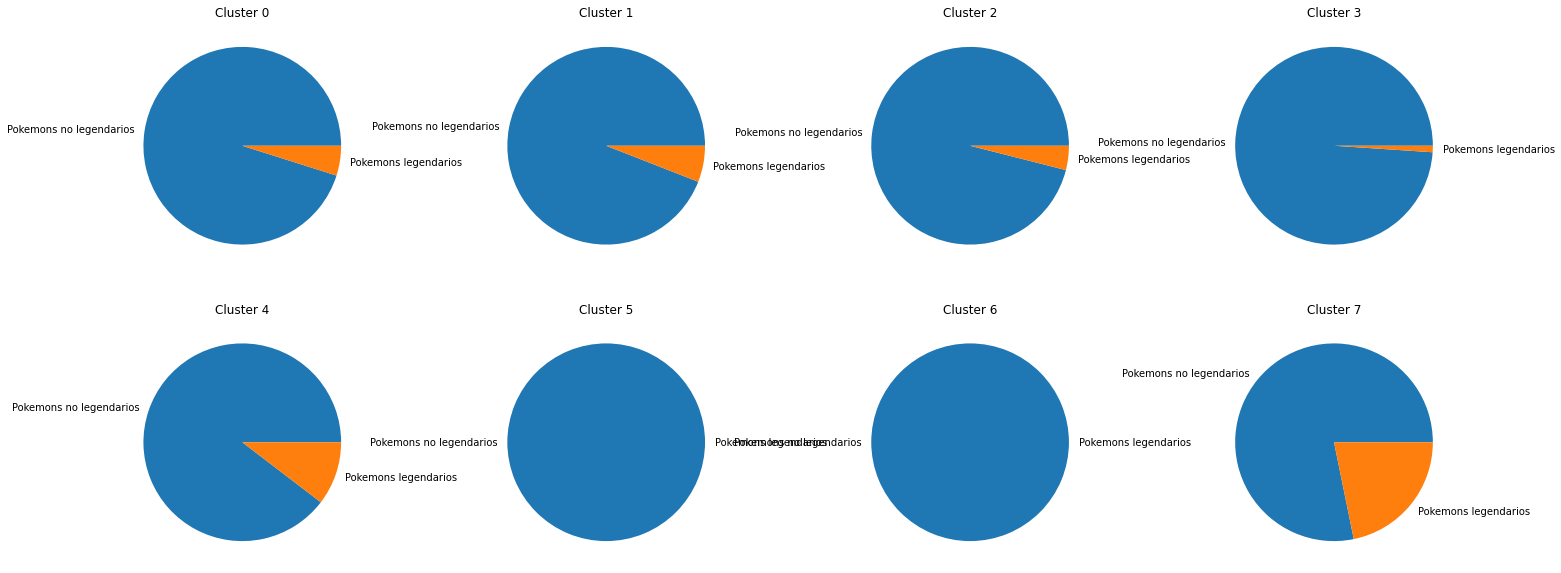

In [ ]:
labels = ["Pokemons no legendarios", "Pokemons legendarios"]
fig, [[ax1, ax2, ax3, ax4], [ax5, ax6, ax7, ax8]] = plt.subplots(figsize=(25,10), nrows=2, ncols=4)
ax1.pie(prop_noLegs_legs_k[0], labels=labels)
ax1.set_title("Cluster 0")
ax2.pie(prop_noLegs_legs_k[1], labels=labels)
ax2.set_title("Cluster 1")
ax3.pie(prop_noLegs_legs_k[2], labels=labels)
ax3.set_title("Cluster 2")
ax4.pie(prop_noLegs_legs_k[3], labels=labels)
ax4.set_title("Cluster 3")
ax5.pie(prop_noLegs_legs_k[4], labels=labels)
ax5.set_title("Cluster 4")
ax6.pie(prop_noLegs_legs_k[5], labels=labels)
ax6.set_title("Cluster 5")
ax7.pie(prop_noLegs_legs_k[6], labels=labels)
ax7.set_title("Cluster 6")
ax8.pie(prop_noLegs_legs_k[7], labels=labels)
ax8.set_title("Cluster 7")
plt.show()